In [2]:
from main import *


In [3]:
train_df_original = pd.read_csv('../data/train.csv')
train_df = train_df_original.copy()

In [19]:
test_df_original = pd.read_csv('../data/test.csv')
test_df = test_df_original.copy()

In [37]:
segments = ['urbana']
text_features = ['titulo', 'descripcion']
features = ['metroscubiertos']
predict_column = 'precio'
carititud_column = 'carititud'


In [33]:
drops(train_df)
train_df = feats.newfeats(train_df)


In [38]:
predic = correr(train_df, segments, text_features, features)
reales = predic[0]
predMod = predic[1]
predNLP = predic[2]

reales   (100117,)
predicc (100117,)
              real   predicted
1      3600000.000 3852421.888
3       650000.000  905606.638
5      1100000.000  999745.015
6      1150000.000 1866190.694
7      4200000.000 3905670.524
...            ...         ...
239991 1450000.000  977480.181
239993 1650000.000 1999490.029
239994 1350000.000 2132789.365
239996 1940000.000 2874941.708
239998 2890000.000 3378056.506

[100117 rows x 2 columns]
---------------------------------------
        Scores para modelo sin NLP
        ---------------------------------------
[array([2.35330072e+12, 3.32706396e-01, 3.69491876e-01, 1.00274400e+07,
       9.85423119e+05, 1.02048370e+06]), array([2.42191133e+12, 3.48235851e-01, 3.33414214e-01, 1.08997051e+07,
       1.05828763e+06, 1.01004040e+06])]
[2.38760603e+12 3.40471124e-01 3.51453045e-01 1.04635726e+07
 1.02185537e+06 1.01526205e+06]
[Pipeline] ............. (step 1 of 3) Processing count, total=  11.8s
[Pipeline] .............. (step 2 of 3) Processing d

/home/tomy/.pyenv/versions/3.6.9/envs/py3.6/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[Pipeline] ............... (step 3 of 3) Processing reg, total= 2.3min
Error calculando metricas en segmento /True:
Mean Squared Logarithmic Error cannot be used when targets contain negative values.
---------------------------------------
        Scores para modelo con NLP
        ---------------------------------------
   mean_squared_error  mean_squared_log_error  r2_score   max_error  \
0   1497551655410.024                   0.288     0.449 6688540.251   

       NRMSE  mean_absolute_error  
0 591206.082           861398.955  
   mean_squared_error  mean_squared_log_error  r2_score   max_error  \
0   2085810159448.250                   0.425     0.507 9689354.395   

       NRMSE  mean_absolute_error  
0 851640.474          1155517.274  
---------------------------------------
        Scores promedio
        ---------------------------------------
[1.79168091e+12 3.56420056e-01 4.77866557e-01 8.18894732e+06
 7.21423278e+05 1.00845811e+06]
              real   predicted
1      3600

[ 199949.0029337   199949.0029337   199949.0029337  ... 6310497.04810026
 6310497.04810026 6310497.04810026]


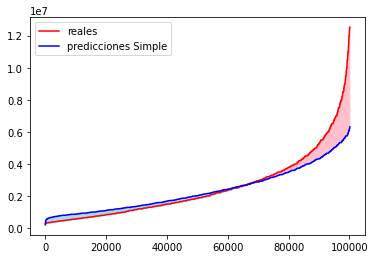

In [39]:

X = np.sort(reales) 
Y = np.sort(predMod) 
print(Y)
plt.plot(X, color='red', label = 'reales')
plt.plot(Y, color='blue', label = 'predicciones Simple')
plt.legend()

plt.fill_between(np.arange(np.size(X)), X, Y, X>Y, color='pink')
plt.fill_between(np.arange(np.size(X)), X, Y, X<Y, color='lightblue')
plt.show()

-2614474.6701830314


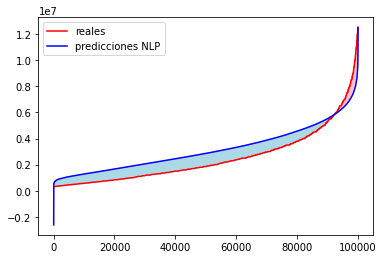

In [40]:
X = np.sort(reales) 
Y = np.sort(predNLP) 
print(Y[0])
plt.plot(X, color='red', label = 'reales')
plt.plot(Y, color='blue', label = 'predicciones NLP')
plt.legend()

plt.fill_between(np.arange(np.size(X)), X, Y, X>Y, color='pink')
plt.fill_between(np.arange(np.size(X)), X, Y, X<Y, color='lightblue')
plt.show()